## To be, or not to be
## Classy Shakespeare plays and players
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the Shakespeare plays dataset from https://www.kaggle.com/kingburrito666/shakespeare-plays
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more classification models to determine the player using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub


In [244]:
#importing required libraries
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
#to divide the dataset into train, test and validation data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
#for visualizing decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from joblib import dump, load

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkhatiwada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#reading given dataset
shakespeareDf = pd.read_csv('../data/Shakespeare_data.csv.zip')
shakespeareDf.head(10)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil
8,9,Henry IV,1.0,1.1.6,KING HENRY IV,Shall daub her lips with her own children's bl...
9,10,Henry IV,1.0,1.1.7,KING HENRY IV,"Nor more shall trenching war channel her fields,"


We want to see the unique plays and number of unique players for each play. We want to choose two players for our binary classification. We are interested in the players having more lines so that we can have more training, test and validation dataset. We will also try to look for two players in the same play so that context(distribution of words) is similar for both players making classification a bit more realistic.  

In [11]:
#finding out the total lines of play and the unique players for each play.
playerStats = shakespeareDf.groupby('Play').agg({'Player':['count','nunique']})
playerStats.columns = ['PlayLines','UniquePlayers']
playerStats = playerStats.reset_index()

def avgPlaylinesPerPlayer(lines,players):
    return lines/players

playerStats['avgLinesPerPlay'] = playerStats.apply(lambda row: avgPlaylinesPerPlayer(row['PlayLines'],
                                                                                     row['UniquePlayers']),axis=1)
playerStats = playerStats.sort_values(by='avgLinesPerPlay', ascending=False)
playerStats.head(10)



,Play,PlayLines,UniquePlayers,avgLinesPerPlay
18,Loves Labours Lost,2986,21,142.190476
17,King Lear,3766,27,139.481481
33,Twelfth Night,2648,19,139.368421
34,Two Gentlemen of Verona,2357,18,130.944444
23,Othello,3762,29,129.724138
32,Troilus and Cressida,3711,29,127.965517
8,Hamlet,4244,35,121.257143
29,The Tempest,2403,20,120.150000
3,Alls well that ends well,3083,26,118.576923
20,Merchant of Venice,2802,24,116.750000


We will visualise top two players of a play having high average lines of each player.

In [23]:
playLLL = shakespeareDf[shakespeareDf['Play']=='Loves Labours Lost']
playersPlayLLL = playLLL.groupby('Player')['PlayerLine'].count().reset_index()
playersPlayLLL.sort_values(by='PlayerLine', ascending=False).head(2)


,Player,PlayerLine
3,BIRON,647
8,FERDINAND,323


The number of lines seems low. Lets look at the play having high number of lines.

In [27]:
playHamlet = shakespeareDf[shakespeareDf['Play']=='Hamlet']
playersPlayHamlet = playHamlet.groupby('Player')['PlayerLine'].count().reset_index()
playersPlayHamlet.sort_values(by='PlayerLine', ascending=False).head(2)


,Player,PlayerLine
14,HAMLET,1582
16,KING CLAUDIUS,594


Although the data seems imbalanced, we will use these two classes for classification.

In [30]:
selectedDf = playHamlet[(playHamlet['Player']=='HAMLET') | (playHamlet['Player']=='KING CLAUDIUS')]
selectedDf1 = selectedDf[['Player','PlayerLine']]
selectedDf1.head(10)

,Player,PlayerLine
32634,KING CLAUDIUS,Though yet of Hamlet our dear brother's death
32635,KING CLAUDIUS,"The memory be green, and that it us befitted"
32636,KING CLAUDIUS,To bear our hearts in grief and our whole kingdom
32637,KING CLAUDIUS,"To be contracted in one brow of woe,"
32638,KING CLAUDIUS,Yet so far hath discretion fought with nature
32639,KING CLAUDIUS,"That we with wisest sorrow think on him,"
32640,KING CLAUDIUS,Together with remembrance of ourselves.
32641,KING CLAUDIUS,"Therefore our sometime sister, now our queen,"
32642,KING CLAUDIUS,"The imperial jointress to this warlike state,"
32643,KING CLAUDIUS,"Have we, as 'twere with a defeated joy,--"


We will now give labels to the player. Lets consider label 1 for 'HAMLET' and 0 for 'KING CLAUDIUS'.

In [40]:

def assignLabel(players):
    if players == 'HAMLET':
        return 1
    else:
        return 0
    
selectedDf1['label'] = selectedDf1['Player'].apply(lambda player:assignLabel(player))
dataset = selectedDf1.sample(frac=1)
dataset.head(10)      

,Player,PlayerLine,label
33915,HAMLET,come then: the appurtenance of welcome is fashion,1
35476,KING CLAUDIUS,"When sorrows come, they come not single spies",0
36218,KING CLAUDIUS,Exit HORATIO,0
34108,HAMLET,"What's Hecuba to him, or he to Hecuba,",1
36415,HAMLET,Thus has he--and many more of the same bevy th...,1
36604,HAMLET,"O good Horatio, what a wounded name,",1
33895,HAMLET,"better--their writers do them wrong, to make them",1
35241,KING CLAUDIUS,Or not at all.,0
36017,HAMLET,"this box, and must the inheritor himself have ...",1
34441,HAMLET,Since my dear soul was mistress of her choice,1


In [56]:
X_train, X_test, y_train, y_test = train_test_split(dataset.PlayerLine, dataset.label, test_size=0.2, random_state=6)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=6)

In [57]:
#displaying the shape of train, test
print('shape of training set {}'.format(X_tr.shape))
print('shape of validation set {}'.format(X_val.shape))
print('shape of test set {}'.format(X_test.shape))

      

shape of training set (1566,)
shape of validation set (174,)
shape of test set (436,)


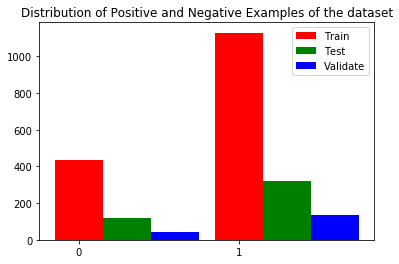

In [78]:
trainLabelDist = y_tr.value_counts()
testLabelDist = y_test.value_counts()
valLabelDist = y_val.value_counts()
width = 0.3
plt.xticks(trainLabelDist.index)
plt.bar(trainLabelDist.index, trainLabelDist.values, width, color = 'red', label='Train')
plt.bar(testLabelDist.index+width, testLabelDist.values, width, color = 'green', label='Test')
plt.bar(valLabelDist.index+2*width, valLabelDist.values, width, color = 'blue', label = 'Validate')
plt.legend()
plt.title('Distribution of Positive and Negative Examples of the dataset')
plt.show()

We will now see how different classifiers will perform on the dataset. Since the feature is text data, we will use appropriate vectorizers for features extraction. Also, we will use scaling/normalize whenever appropriate. Lets start with Decision tree classifier. We will not consider english stop words for vectorization. Also we will pass `class_weight='balanced'` to somehow reduce the effect of imbalance dataset.

### Decision Tree Classifier
Decision tree needs categorical data or yes/no data. So, we will use binary count vectorizer provided by sklearn.

In [167]:
stop_words = stopwords.words('english')
binaryCountVect = CountVectorizer(binary=True, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             max_df=0.99)#word occurring in almost all document are ignored. 
trainFeatures = binaryCountVect.fit_transform(X_tr)
valFeatures = binaryCountVect.transform(X_val)


def getFeaturesName(binaryCountVect):
    terms = np.array(list(binaryCountVect.vocabulary_.keys())) 
    indices = np.array(list(binaryCountVect.vocabulary_.values())) 
    inverse_vocabulary = terms[np.argsort(indices)]
    return inverse_vocabulary

First we will use a decision tree of depth 1 for visulaization. Then we will use validation dataset to select best value for hyperparameter depth. 

In [168]:
dtModel = DecisionTreeClassifier(max_depth=1, random_state=33, class_weight='balanced')
dtModel.fit(trainFeatures,y_tr)

valPrediction = dtModel.predict(valFeatures)

accuracy = accuracy_score(y_val, valPrediction)
print(accuracy)

0.7816091954022989


Visualizing the decision tree using graphviz library.

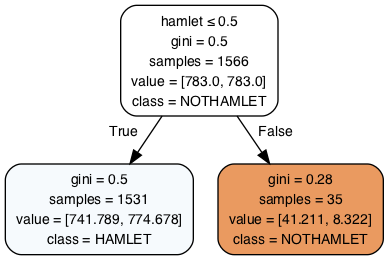

In [169]:
dot_data = StringIO()
export_graphviz(dtModel, out_file=dot_data, feature_names=getFeaturesName(binaryCountVect), 
               class_names=['NOTHAMLET','HAMLET'], filled=True, rounded=True, 
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

From the depth of 1 decision tree, we see that if there is no word Hamlet, then it classifies the example to be of Hamlet class. The decision tree discovered the interesting fact that one will not  mention his own name often.

In [172]:
max_accuracy = 0
bestModel = None
bestDepth = None
for depth in range(1,10):
    dtModel = DecisionTreeClassifier(max_depth=depth, random_state=33,class_weight='balanced')
    dtModel.fit(trainFeatures,y_tr)

    valPrediction = dtModel.predict(valFeatures)

    accuracy = accuracy_score(y_val, valPrediction)
    if(accuracy>max_accuracy):
        bestModel = dtModel
        bestDepth = depth
        max_accuracy = accuracy
print(bestModel)
print(bestDepth)
print(max_accuracy)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=33,
            splitter='best')
4
0.7873563218390804


It is seen that 4 is the best depth for this validation data. Now we will use the best model to train all the training datasets evaluate on test dataset.

In [181]:
allTrainFeatures = binaryCountVect.fit_transform(X_train)
testFeatures = binaryCountVect.transform(X_test)

bestModel.fit(allTrainFeatures, y_train)
dump(bestModel, '../models/decisiontree.joblib')

loadedModel = load('../models/decisiontree.joblib')
testPrediction = loadedModel.predict(testFeatures)

accuracy = accuracy_score(y_test, testPrediction)
print(accuracy)

0.7362385321100917


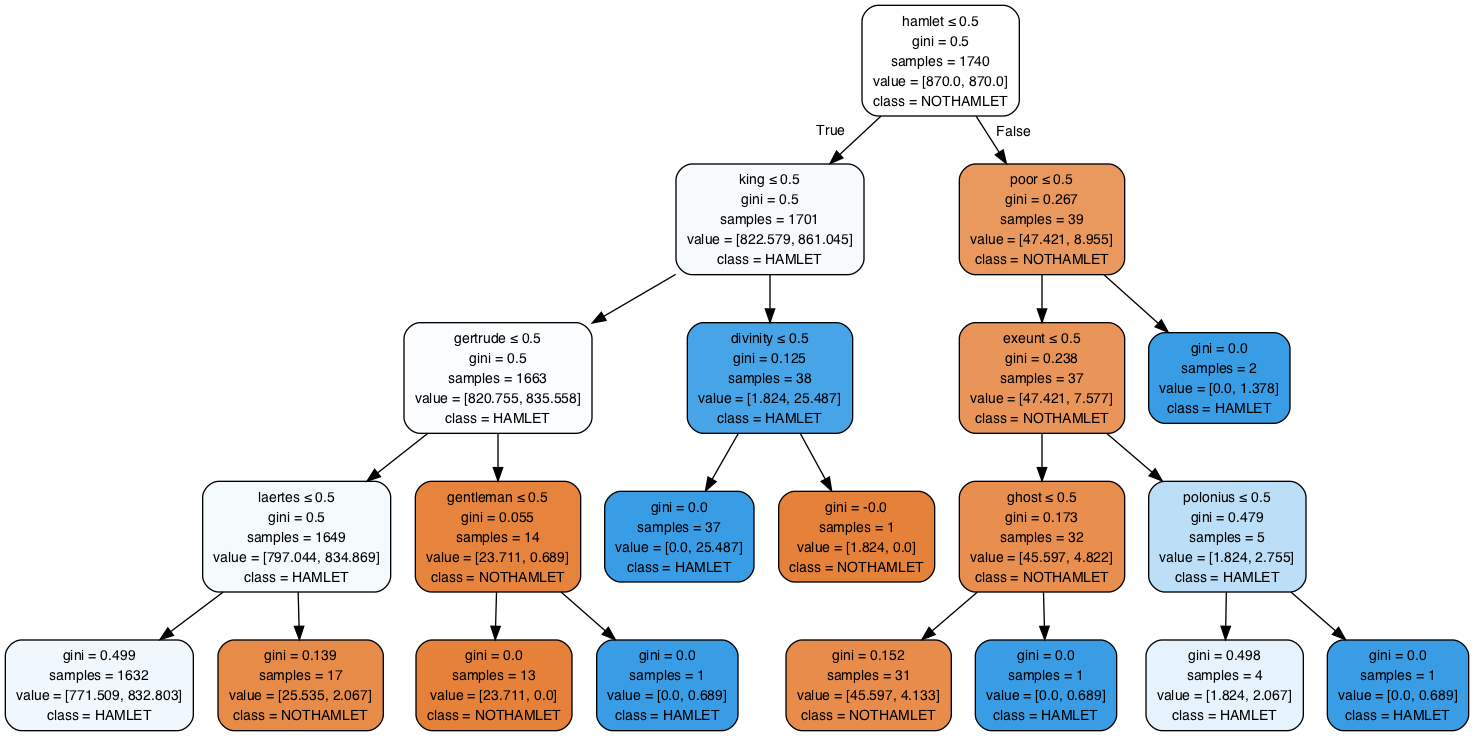

In [182]:
dot_data = StringIO()
export_graphviz(bestModel, out_file=dot_data, feature_names=getFeaturesName(binaryCountVect), 
               class_names=['NOTHAMLET','HAMLET'], filled=True, rounded=True, 
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Now we will use another approach of classification.

### Logistic regression

In [248]:
countVectorizerLR = CountVectorizer(binary=False, stop_words=stop_words,
                            token_pattern="[a-zA-Z]{2,}",
                            min_df=2, max_df=0.99)

trainFeaturesLR = countVectorizerLR.fit_transform(X_tr)
valFeaturesLR = countVectorizerLR.transform(X_val)

Now, we will use different values of hyperparameter C and find the best model.

In [252]:
max_accuracy = 0
bestModelLR = None
bestCLR = None
for c in [0.07,0.09,0.1,0.2,0.3,0.5,1]:
    LRModel = LogisticRegression(random_state=33, class_weight='balanced', verbose=0, C=c)
    LRModel.fit(trainFeaturesLR,y_tr)

    valPrediction = LRModel.predict(valFeaturesLR)

    accuracy = accuracy_score(y_val, valPrediction)
    if(accuracy>max_accuracy):
        bestModelLR = LRModel
        bestCLR = c
        max_accuracy = accuracy
print(bestModelLR)
print(bestCLR)
print(max_accuracy)



LogisticRegression(C=0.09, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.09
0.7586206896551724


We found that hyperparameter C= 0.1 is the best. Now, we will look for the most important features of dataset which are responsible for classifying players.

In [253]:
indicesForPosEg = np.argsort(-1*bestModelLR.coef_)[:,0:5]
indicesForNegEg = np.argsort(bestModelLR.coef_)[:,0:5]
featuresName = getFeaturesName(countVectorizerLR)
sigWordForPosEg = featuresName[indicesForPosEg]
print("Top 5 significant words for positive examples: {}".format(sigWordForPosEg))
sigWordForNegEg = featuresName[indicesForNegEg]
print("Top 5 significant words for negative examples: {}".format(sigWordForNegEg))


Top 5 significant words for positive examples: [['hole' 'quite' 'lived' 'slave' 'since']]
Top 5 significant words for negative examples: [['get' 'humbly' 'fool' 'escape' 'looks']]


In [254]:
allTrainFeaturesLR = countVectorizerLR.fit_transform(X_train)
testFeaturesLR = countVectorizerLR.transform(X_test)

bestModelLR.fit(allTrainFeaturesLR, y_train)
dump(bestModelLR, '../models/logisticregression.joblib')

loadedModelLR = load('../models/logisticregression.joblib')
testPredictionLR = loadedModelLR.predict(testFeaturesLR)

accuracyLR = accuracy_score(y_test, testPredictionLR)
print(accuracyLR)

print(confusion_matrix(y_test,testPredictionLR))

0.6536697247706422
[[ 49  68]
 [ 83 236]]


In [238]:
indicesForPosEg = np.argsort(-1*loadedModelLR.coef_)[:,0:5]
indicesForNegEg = np.argsort(loadedModelLR.coef_)[:,0:5]
featuresName = getFeaturesName(countVectorizerLR)
sigWordForPosEg = featuresName[indicesForPosEg]
print("Top 5 significant words for positive examples: {}".format(sigWordForPosEg))
sigWordForNegEg = featuresName[indicesForNegEg]
print("Top 5 significant words for positive examples: {}".format(sigWordForNegEg))


Top 5 significant words for positive examples: [['sir' 'king' 'mother' 'thee' 'god']]
Top 5 significant words for positive examples: [['hamlet' 'laertes' 'gertrude' 'father' 'son']]


We observed that the accuracy significantly dropped when evaluation was done on the test set. It might be due to overfitting or different distribution of words in the test set.